In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader 
from data_loader import *
import torchvision
from unet_model import *

In [2]:
x_train_data=np.load ('x_train.npy')
y_train_data=np.load ('y_train.npy')
# TODO change y_valid.npy shape

x_valid_data= np.load('x_valid.npy')
y_valid_data= np.load('y_valid.npy')


In [3]:
y_valid_data.shape

(297, 192, 192)

In [4]:
x_train_data=x_train_data [0:300]
y_train_data=y_train_data[0:300]
x_valid_data=x_valid_data [0:50]
y_valid_data=y_valid_data[0:50]


In [5]:
 # ==============Dataset=================
#mri_dataset = MRIDataset(x_data, y_data, transform=ToTensor())
#composed = torchvision.transforms.Compose([ToTensor(), MulTransform(100)])
mri_train_dataset = MRIDataset(x_train_data, y_train_data, transform=ToTensor())
mri_valid_dataset=MRIDataset (x_valid_data, y_valid_data, transform=ToTensor())


In [6]:
# ===========Data Iterator===========
train_iter = DataLoader(dataset=mri_train_dataset, batch_size=10, shuffle=True)
valid_iter=DataLoader(dataset=mri_valid_dataset, batch_size=5, shuffle=True)


In [7]:
for idx,(x_train,y_train) in enumerate(train_iter):
  print(f"img: \n{x_train.shape}")
  break




img: 
torch.Size([10, 192, 192])


In [8]:
torch.manual_seed(101)
UNETmodel =  UNet(n_channels=1, n_classes=1, bilinear=True)
criterion = nn.BCEWithLogitsLoss()#nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(UNETmodel.parameters(), lr=0.001)

In [9]:
'''with torch.no_grad():
    y=nn.Sigmoid()(y_pred)
    y[y<0.5]=0
    y[y>=0.5]=1
    y=y.numpy().astype(np.uint8)'''

'with torch.no_grad():\n    y=nn.Sigmoid()(y_pred)\n    y[y<0.5]=0\n    y[y>=0.5]=1\n    y=y.numpy().astype(np.uint8)'

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
    
def accuracy(pred,train):
    with torch.no_grad():
        pred=nn.Sigmoid()(pred)
        pred[pred<0.5]=0
        pred[pred>=0.5]=1
        pred=pred.numpy().astype(np.uint8)
        train=train.numpy().astype(np.uint8)
    
    pred=pred.ravel ()
    train=train.ravel ()
    match =len (np.where(pred==train) [0])
   # match =len (np.where((pred==train)& (pred==1)) [0]) # check if 1 are matches
    #Original_total=len (np.where(train==1)[0]) # total one in train image
    
   
   
    return ((match/len(train))*100)          

In [11]:
#count_parameters(UNETmodel)

In [12]:
#accuracy (y_pred,y_train)

In [13]:
print (y_pred.shape,y_train.shape)

NameError: name 'y_pred' is not defined

In [14]:
import time
#atart_time=time.time ()

epoch=60

#max_trn_batch=80
#max_tst_batch=30
train_losses=[]
valid_losses=[]
train_acuracy=[]
valid_acuracy=[]
previousLoss=10
earlystoping=0


for i in range (epoch):
    
      
    # Run the training batches
    for b, (X_train1, y_train1) in enumerate(train_iter):
        
        
        X_train=X_train1.view(X_train1.shape[0] ,1,192,192) 
        y_train=y_train1.view(y_train1.shape[0] ,1,192,192)

        # Limit the number of batches
        #if b == max_trn_batch:
         #   break
        b+=1
        # Apply the model
        y_pred = UNETmodel(X_train)
        accur=accuracy(y_pred,y_train)
        loss = criterion(y_pred, y_train)
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
             # Print interim results
        #if b%10 == 0:

        print(f'epoch: {i:2}  batch: {b:4} [{b:6}/30]  loss: {loss.item():10.8f}  \
    accuracy: {accur:.4f}%')

    train_losses.append(loss.item())
    train_acuracy.append(accur)
    with torch.no_grad():
        UNETmodel.eval()
    
        for b, (X_valid1, y_valid1) in enumerate(valid_iter):

            X_valid=X_valid1.view(X_valid1.shape[0] ,1,192,192) 
            y_valid=y_valid1.view(y_valid1.shape[0] ,1,192,192)
            y_val=UNETmodel(X_valid) # y_val is predicted images of validation  
            valid_losse= criterion(y_val, y_valid)
            valid_accur=accuracy(y_val, y_valid)
    print (f'previous loss :{previousLoss} and valid loss is {valid_losse}')
    valid_losses.append(valid_losse.item())
    valid_acuracy.append(valid_accur)
       
    if  round(previousLoss,3)<= round (valid_losse.item(),3):
        earlystoping+=1
        print (f'earlystopping increasing......{earlystoping}')
        if earlystoping>=3:
            print (f'Model is stoping......{earlystoping}')
            break
    else:
        earlystoping=0
        print (f'earlystoping is getting 0......{earlystoping}')
        
    previousLoss=valid_losse.item()
print (f'=================training is done and model is saving ======================')
path='umodel.pth'
torch.save(UNETmodel.state_dict(), path)
print (f'=================model is saved ======================')
    
            
    

        
#print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:    1 [     1/30]  loss: 0.94380242      accuracy: 6.9558%
epoch:  0  batch:    2 [     2/30]  loss: 0.83711851      accuracy: 61.0067%
epoch:  0  batch:    3 [     3/30]  loss: 0.77051401      accuracy: 60.1202%
epoch:  0  batch:    4 [     4/30]  loss: 0.71095061      accuracy: 74.4078%
epoch:  0  batch:    5 [     5/30]  loss: 0.67988533      accuracy: 67.7165%
epoch:  0  batch:    6 [     6/30]  loss: 0.63167274      accuracy: 75.5284%
epoch:  0  batch:    7 [     7/30]  loss: 0.60622799      accuracy: 77.9167%
epoch:  0  batch:    8 [     8/30]  loss: 0.57953686      accuracy: 83.3209%
epoch:  0  batch:    9 [     9/30]  loss: 0.55075198      accuracy: 85.4110%
epoch:  0  batch:   10 [    10/30]  loss: 0.52970350      accuracy: 87.5594%
epoch:  0  batch:   11 [    11/30]  loss: 0.52614701      accuracy: 91.7668%
epoch:  0  batch:   12 [    12/30]  loss: 0.50584632      accuracy: 91.8530%
epoch:  0  batch:   13 [    13/30]  loss: 0.48448384      accuracy: 92.7002%


epoch:  3  batch:   14 [    14/30]  loss: 0.08809133      accuracy: 96.2652%
epoch:  3  batch:   15 [    15/30]  loss: 0.12103570      accuracy: 95.7156%
epoch:  3  batch:   16 [    16/30]  loss: 0.09714182      accuracy: 96.1833%
epoch:  3  batch:   17 [    17/30]  loss: 0.10157590      accuracy: 96.0585%
epoch:  3  batch:   18 [    18/30]  loss: 0.10858154      accuracy: 95.7259%
epoch:  3  batch:   19 [    19/30]  loss: 0.10266400      accuracy: 96.1803%
epoch:  3  batch:   20 [    20/30]  loss: 0.08716398      accuracy: 96.5565%
epoch:  3  batch:   21 [    21/30]  loss: 0.10009615      accuracy: 96.0585%
epoch:  3  batch:   22 [    22/30]  loss: 0.11599839      accuracy: 95.1807%
epoch:  3  batch:   23 [    23/30]  loss: 0.10446429      accuracy: 95.4565%
epoch:  3  batch:   24 [    24/30]  loss: 0.10124655      accuracy: 95.7430%
epoch:  3  batch:   25 [    25/30]  loss: 0.08760684      accuracy: 96.3186%
epoch:  3  batch:   26 [    26/30]  loss: 0.08636234      accuracy: 96.4228%

epoch:  6  batch:   27 [    27/30]  loss: 0.06463285      accuracy: 97.2523%
epoch:  6  batch:   28 [    28/30]  loss: 0.07490402      accuracy: 96.8462%
epoch:  6  batch:   29 [    29/30]  loss: 0.06021790      accuracy: 97.5279%
epoch:  6  batch:   30 [    30/30]  loss: 0.05491965      accuracy: 97.7124%
previous loss :0.05954756215214729 and valid loss is 0.0755700021982193
earlystopping increasing......1
epoch:  7  batch:    1 [     1/30]  loss: 0.07151413      accuracy: 97.1604%
epoch:  7  batch:    2 [     2/30]  loss: 0.08168563      accuracy: 96.4608%
epoch:  7  batch:    3 [     3/30]  loss: 0.06123157      accuracy: 97.5301%
epoch:  7  batch:    4 [     4/30]  loss: 0.07505561      accuracy: 96.9236%
epoch:  7  batch:    5 [     5/30]  loss: 0.07357328      accuracy: 97.0890%
epoch:  7  batch:    6 [     6/30]  loss: 0.07714201      accuracy: 96.7977%
epoch:  7  batch:    7 [     7/30]  loss: 0.05697027      accuracy: 97.5705%
epoch:  7  batch:    8 [     8/30]  loss: 0.07070

epoch: 10  batch:    8 [     8/30]  loss: 0.04797484      accuracy: 98.0206%
epoch: 10  batch:    9 [     9/30]  loss: 0.05827295      accuracy: 97.6343%
epoch: 10  batch:   10 [    10/30]  loss: 0.05225782      accuracy: 97.8451%
epoch: 10  batch:   11 [    11/30]  loss: 0.05256791      accuracy: 97.7772%
epoch: 10  batch:   12 [    12/30]  loss: 0.05581668      accuracy: 97.7639%
epoch: 10  batch:   13 [    13/30]  loss: 0.05376458      accuracy: 97.7903%
epoch: 10  batch:   14 [    14/30]  loss: 0.05735528      accuracy: 97.6074%
epoch: 10  batch:   15 [    15/30]  loss: 0.04630073      accuracy: 98.1415%
epoch: 10  batch:   16 [    16/30]  loss: 0.05059241      accuracy: 97.8876%
epoch: 10  batch:   17 [    17/30]  loss: 0.05322646      accuracy: 97.7656%
epoch: 10  batch:   18 [    18/30]  loss: 0.05300810      accuracy: 97.8315%
epoch: 10  batch:   19 [    19/30]  loss: 0.04614590      accuracy: 98.0518%
epoch: 10  batch:   20 [    20/30]  loss: 0.04968761      accuracy: 97.9042%

epoch: 13  batch:   21 [    21/30]  loss: 0.04954875      accuracy: 97.9134%
epoch: 13  batch:   22 [    22/30]  loss: 0.04664038      accuracy: 97.9951%
epoch: 13  batch:   23 [    23/30]  loss: 0.04180164      accuracy: 98.2606%
epoch: 13  batch:   24 [    24/30]  loss: 0.04589666      accuracy: 98.1321%
epoch: 13  batch:   25 [    25/30]  loss: 0.05294542      accuracy: 97.7355%
epoch: 13  batch:   26 [    26/30]  loss: 0.04959034      accuracy: 97.9088%
epoch: 13  batch:   27 [    27/30]  loss: 0.04723594      accuracy: 98.0740%
epoch: 13  batch:   28 [    28/30]  loss: 0.04852648      accuracy: 97.9679%
epoch: 13  batch:   29 [    29/30]  loss: 0.03953396      accuracy: 98.3341%
epoch: 13  batch:   30 [    30/30]  loss: 0.04709777      accuracy: 98.0444%
previous loss :0.04813874512910843 and valid loss is 0.06548555195331573
earlystopping increasing......1
epoch: 14  batch:    1 [     1/30]  loss: 0.04338250      accuracy: 98.1963%
epoch: 14  batch:    2 [     2/30]  loss: 0.0303

In [ ]:
'''print("Model's state_dict:")
for param_tensor in UNETmodel.state_dict():
    print(param_tensor, "\t", UNETmodel.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])'''

plt.imshor [1,0,45,45]

tensor(6.4393)


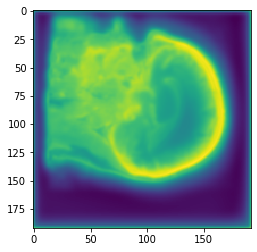

In [15]:
with torch.no_grad():
    plt.imshow (y_pred[0,0])
    print (y_pred[0,0].max())
    

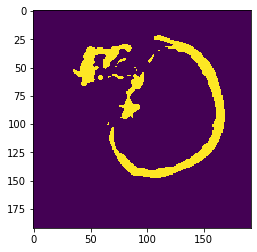

In [16]:
with torch.no_grad():
    y=nn.Sigmoid()(y_pred)
    y[y<0.2]=0
    y[y>=0.2]=1
    y=y.numpy().astype(np.uint8)
    plt.imshow (y[0,0])

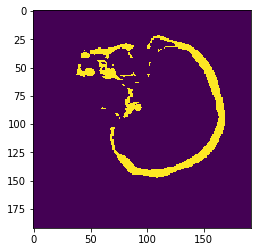

In [17]:
with torch.no_grad():
    plt.imshow (y_train[0,0])

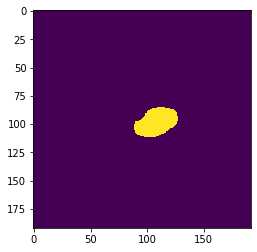

In [18]:
with torch.no_grad():
    plt.imshow (y_valid[0,0])

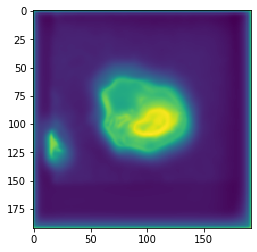

In [19]:
with torch.no_grad():
    plt.imshow (y_val[0,0])

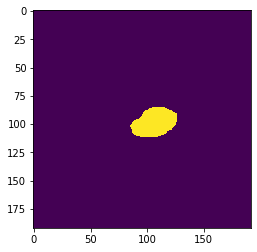

In [20]:
# predicted for validation
with torch.no_grad():
    y=nn.Sigmoid()(y_val)
    y[y<0.2]=0
    y[y>=0.2]=1
    y=y.numpy().astype(np.uint8)
    plt.imshow (y[0,0])

In [ ]:

'''with torch.no_grad():
    pred=nn.Sigmoid()(y_pred)
    pred[pred<0.5]=0
    pred[pred>=0.5]=1
    pred=pred.numpy().astype(np.uint8)
    train=y_train.numpy().astype(np.uint8)
    pred=pred.ravel ()
    train=train.ravel ()
    match=len (np.where(pred==train)[0])
    acc=((match/len(pred))*100) '''         

In [ ]:
#train_losses_array =np.array ([loss.item() for loss in train_losses])
#print(f'train losses is {train_losses_array}')
#valid_losses_array=np.array([loss.item() for loss in valid_losses])
#print(f'valid losses is {valid_losses_array}')

In [21]:
train_losses_array =np.array (train_losses)
print(f'train accuracy is {train_losses_array}')
valid_losses_array =np.array (valid_losses)
print(f'valid accuracy is {valid_losses_array}')

train accuracy is [0.37440822 0.10248201 0.10895495 0.09089427 0.07709326 0.07097311
 0.05491965 0.07109841 0.06550968 0.06528601 0.04529122 0.05351749
 0.04169786 0.04709777 0.05718499 0.04315705]
valid accuracy is [2.93693709 0.09542404 0.07765558 0.08082358 0.07844673 0.05954756
 0.07557    0.06077458 0.07083697 0.05261262 0.08782216 0.0515571
 0.04813875 0.06548555 0.06599662 0.07360593]


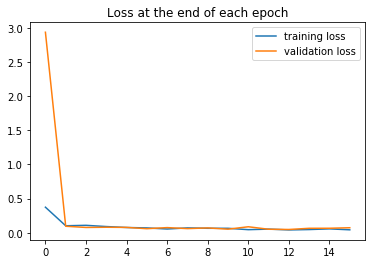

In [22]:
#Loss at the end of each epoch
plt.plot(train_losses_array, label='training loss')
plt.plot(valid_losses_array, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [23]:
train_accuracy_array =np.array (train_acuracy)
print(f'train accuracy is {train_accuracy_array}')
valid_accuracy_array=np.array( valid_acuracy)
print(f'valid accuracy is {valid_accuracy_array}')

train accuracy is [95.71967231 95.55094401 95.15977648 96.61539714 96.89751519 96.88368056
 97.71240234 97.12863498 97.41753472 97.22439236 98.02381727 97.74631076
 98.24924045 98.04443359 97.54014757 98.27148438]
valid accuracy is [ 9.4938151  96.01128472 97.09852431 96.93630642 96.8891059  97.5797526
 97.1999783  97.51193576 97.02582465 97.74576823 96.23372396 97.80978733
 98.1391059  97.39908854 97.24175347 97.17556424]


In [24]:
type (train_acuracy)

list

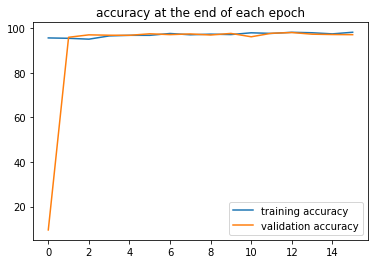

In [25]:
#Accuracy at the end of each epoch
plt.plot(train_accuracy_array, label='training accuracy')
plt.plot(valid_accuracy_array, label='validation accuracy')
plt.title('accuracy at the end of each epoch')
plt.legend();

In [ ]:
round (valid_losse.item(),3)

In [ ]:
round(previousLoss,3)

In [ ]:
previousLoss

In [ ]:
train_losses

In [ ]:
type (train_losses)